2024-07-16 13:43:08,728 - INFO - Fetching historical data for BTC/USDT


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1530 - val_loss: 0.0103
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0119 - val_loss: 0.0076
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0096 - val_loss: 0.0080
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0088 - val_loss: 0.0059
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0084 - val_loss: 0.0053
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0069 - val_loss: 0.0086
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0089 - val_loss: 0.0046
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0063 - val_loss: 0.0059
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


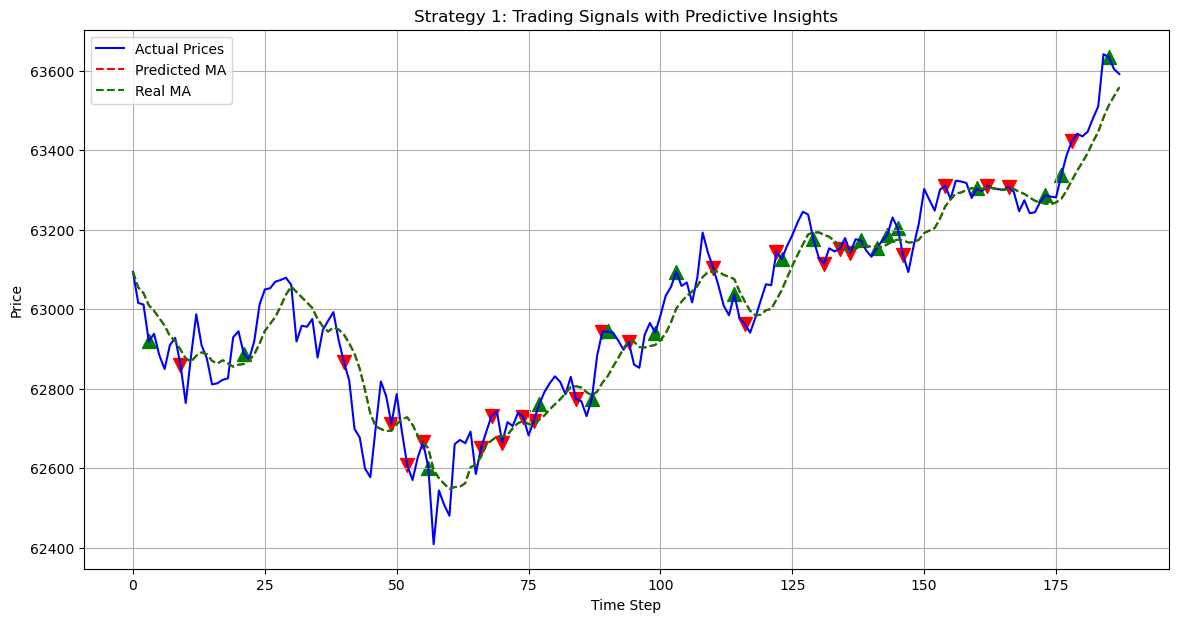

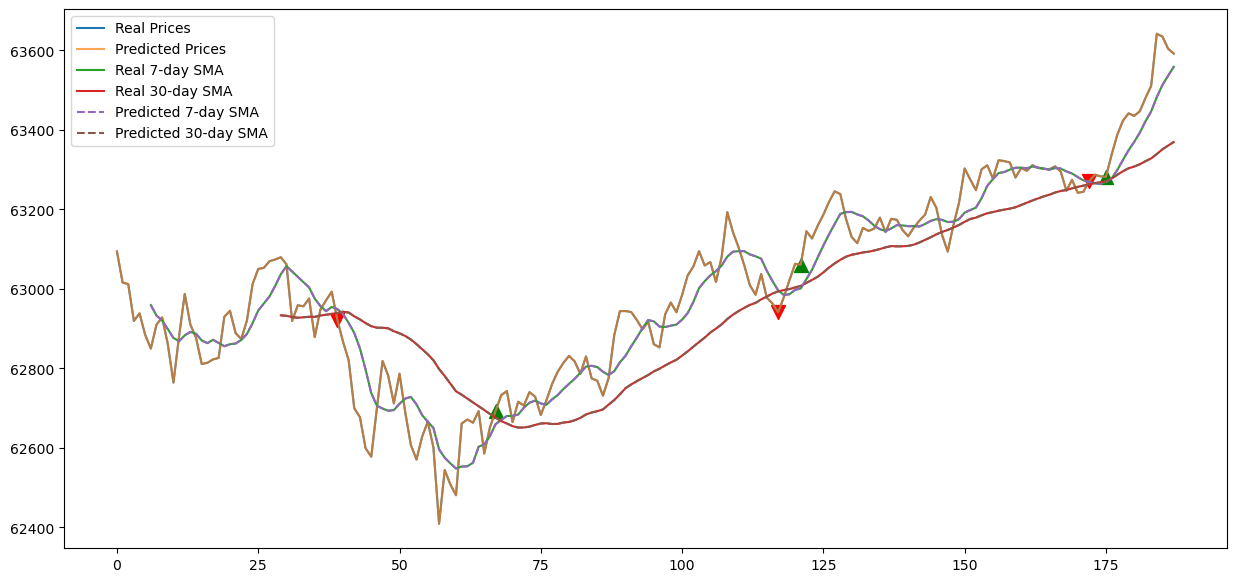

In [1]:
import asyncio
import numpy as np
import pandas as pd
import ccxt.async_support as ccxt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import logging

import nest_asyncio
nest_asyncio.apply()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    'apiKey': '',
    'secret': '',
    'symbol': 'BTC/USDT',
    'timeframe': '1m',
    'limit': 1000,
    'look_back': 60,
    'batch_size': 32,
    'epochs': 10,
    'test_size': 0.2
}

def init_exchange(api_key, secret):
    return ccxt.bybit({
        'apiKey': api_key,
        'secret': secret,
        'enableRateLimit': True
    })

async def fetch_historical_data(exchange, symbol, timeframe, limit=200):
    logging.info(f'Fetching historical data for {symbol}')
    data = await exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    await exchange.close()  # Ensure to close the exchange connection
    return df

def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :-1])
        y.append(data[i + look_back, 3])
    return np.array(X), np.array(y)

async def main():
    exchange = init_exchange(CONFIG['apiKey'], CONFIG['secret'])
    data = await fetch_historical_data(exchange, CONFIG['symbol'], CONFIG['timeframe'], CONFIG['limit'])
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['open', 'high', 'low', 'close', 'volume']])
    
    X, y = create_sequences(scaled_data, CONFIG['look_back'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=CONFIG['test_size'], shuffle=False)
    
    model = Sequential([
        Input(shape=(CONFIG['look_back'], X_train.shape[2])),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    history = model.fit(X_train, y_train, epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'], validation_split=0.1, verbose=1)
    
    predicted = model.predict(X_test, batch_size=CONFIG['batch_size'])
    predicted_prices = scaler.inverse_transform(np.concatenate((scaled_data[-len(predicted):, :-1], predicted), axis=1))[:, 3]
    real_prices = data['close'][-len(predicted_prices):].values

    # Integrate real and predicted prices into a DataFrame for further analysis
    combined_data = pd.DataFrame({
        'real_prices': real_prices,
        'predicted_prices': predicted_prices
    })

    # Strategy 1: Moving averages and trading signals
    combined_data['real_ma'] = combined_data['real_prices'].rolling(window=7, min_periods=1).mean()
    combined_data['predicted_ma'] = combined_data['predicted_prices'].rolling(window=7, min_periods=1).mean()

    signals = []
    for i in range(1, len(combined_data)):
        if (combined_data['predicted_ma'].iloc[i] > combined_data['real_ma'].iloc[i] and
            combined_data['predicted_ma'].iloc[i-1] <= combined_data['real_ma'].iloc[i-1]):
            signals.append('Buy')
        elif (combined_data['predicted_ma'].iloc[i] < combined_data['real_ma'].iloc[i] and
              combined_data['predicted_ma'].iloc[i-1] >= combined_data['real_ma'].iloc[i-1]):
            signals.append('Sell')
        else:
            signals.append('Hold')

    # Plotting Strategy 1 results
    plt.figure(figsize=(14, 7))
    plt.plot(combined_data['real_prices'], label='Actual Prices', color='blue')
    plt.plot(combined_data['predicted_ma'], label='Predicted MA', color='red', linestyle='--')
    plt.plot(combined_data['real_ma'], label='Real MA', color='green', linestyle='--')
    plt.title('Strategy 1: Trading Signals with Predictive Insights')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    for i, signal in enumerate(signals):
        if signal == 'Buy':
            plt.scatter(i, combined_data['real_prices'].iloc[i], color='green', marker='^', s=100)
        elif signal == 'Sell':
            plt.scatter(i, combined_data['real_prices'].iloc[i], color='red', marker='v', s=100)

    plt.show()

    # Strategy 2: Dynamic moving averages and trading signals
    combined_data['Real_Short_SMA'] = combined_data['real_prices'].rolling(window=7).mean()
    combined_data['Real_Long_SMA'] = combined_data['real_prices'].rolling(window=30).mean()
    combined_data['Predicted_Short_SMA'] = combined_data['predicted_prices'].rolling(window=7).mean()
    combined_data['Predicted_Long_SMA'] = combined_data['predicted_prices'].rolling(window=30).mean()

    signals = []
    for i in range(1, len(combined_data)):
        if combined_data['Predicted_Short_SMA'].iloc[i] > combined_data['Predicted_Long_SMA'].iloc[i] and combined_data['Predicted_Short_SMA'].iloc[i-1] <= combined_data['Predicted_Long_SMA'].iloc[i-1]:
            signals.append('Buy')
        elif combined_data['Predicted_Short_SMA'].iloc[i] < combined_data['Predicted_Long_SMA'].iloc[i] and combined_data['Predicted_Short_SMA'].iloc[i-1] >= combined_data['Predicted_Long_SMA'].iloc[i-1]:
            signals.append('Sell')
        else:
            signals.append('Hold')

    # Plotting Strategy 2 results
    plt.figure(figsize=(15, 7))
    plt.plot(combined_data['real_prices'], label='Real Prices')
    plt.plot(combined_data['predicted_prices'], label='Predicted Prices', alpha=0.7)
    plt.plot(combined_data['Real_Short_SMA'], label='Real 7-day SMA')
    plt.plot(combined_data['Real_Long_SMA'], label='Real 30-day SMA')
    plt.plot(combined_data['Predicted_Short_SMA'], label='Predicted 7-day SMA', linestyle='--')
    plt.plot(combined_data['Predicted_Long_SMA'], label='Predicted 30-day SMA', linestyle='--')
    for i, signal in enumerate(signals):
        if signal == 'Buy':
            plt.scatter(i, combined_data['real_prices'].iloc[i], color='green', marker='^', s=100)
        elif signal == 'Sell':
            plt.scatter(i, combined_data['real_prices'].iloc[i], color='red', marker='v', s=100)
    plt.legend()
    plt.show()

await main()


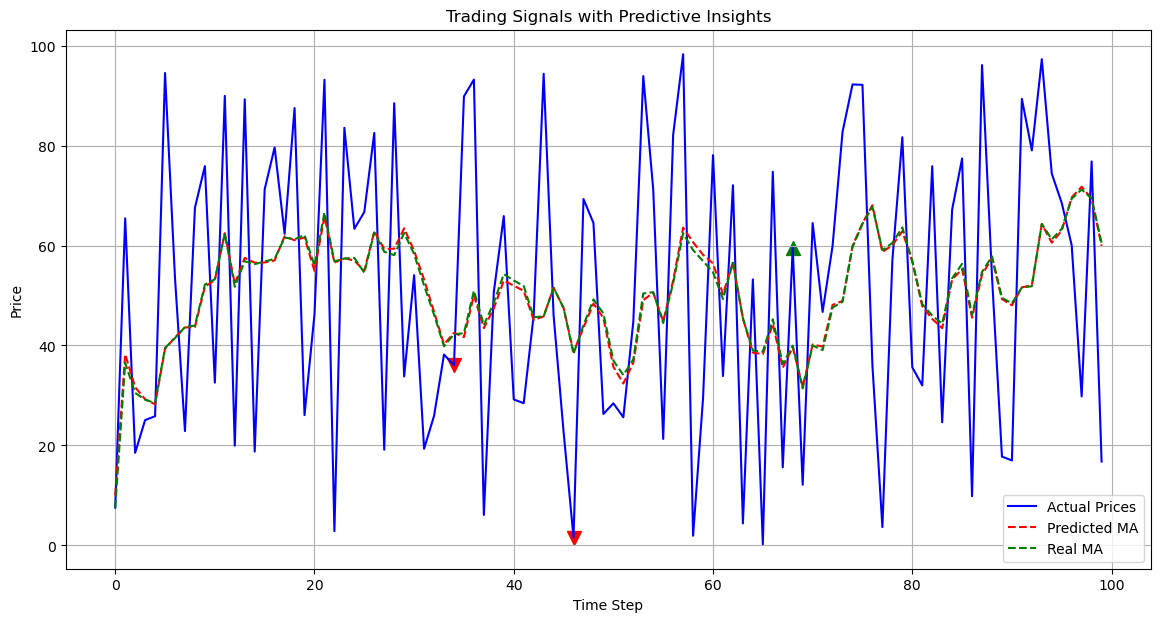

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def add_moving_averages(prices, predictions, window=7):
    data = pd.DataFrame({
        'real_prices': prices,
        'predicted_prices': predictions
    })
    data['real_ma'] = data['real_prices'].rolling(window=window, min_periods=1).mean()
    data['predicted_ma'] = data['predicted_prices'].rolling(window=window, min_periods=1).mean()
    return data

def generate_trade_signals(df, threshold=0.01):
    signals = []
    for i in range(1, len(df)):
        if (df['predicted_ma'].iloc[i] > df['real_ma'].iloc[i] and
            df['predicted_ma'].iloc[i-1] <= df['real_ma'].iloc[i-1]):
            if (df['predicted_ma'].iloc[i] - df['real_ma'].iloc[i]) / df['real_ma'].iloc[i] > threshold:
                signals.append('Buy')
            else:
                signals.append('Hold')
        elif (df['predicted_ma'].iloc[i] < df['real_ma'].iloc[i] and
              df['predicted_ma'].iloc[i-1] >= df['real_ma'].iloc[i-1]):
            if (df['real_ma'].iloc[i] - df['predicted_ma'].iloc[i]) / df['real_ma'].iloc[i] > threshold:
                signals.append('Sell')
            else:
                signals.append('Hold')
        else:
            signals.append('Hold')
    return signals

# Пример данных
real_prices = np.random.rand(100) * 100
predicted_prices = real_prices + np.random.normal(0, 2, 100)  # небольшие изменения

df = add_moving_averages(real_prices, predicted_prices)
signals = generate_trade_signals(df)

plt.figure(figsize=(14, 7))
plt.plot(df['real_prices'], label='Actual Prices', color='blue')
plt.plot(df['predicted_ma'], label='Predicted MA', color='red', linestyle='--')
plt.plot(df['real_ma'], label='Real MA', color='green', linestyle='--')
plt.title('Trading Signals with Predictive Insights')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

for i, signal in enumerate(signals):
    if signal == 'Buy':
        plt.scatter(i, df['real_prices'].iloc[i], color='green', marker='^', s=100)
    elif signal == 'Sell':
        plt.scatter(i, df['real_prices'].iloc[i], color='red', marker='v', s=100)

plt.show()

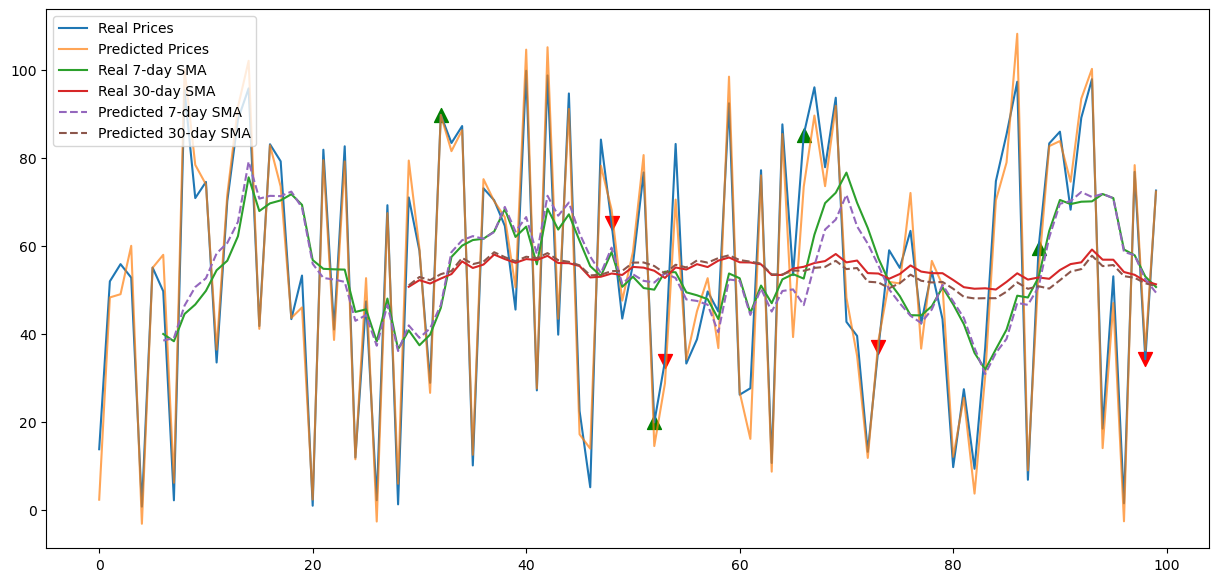

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_sma(data, window):
    return data.rolling(window=window).mean()

def merge_data(real_prices, predicted_prices):
    df = pd.DataFrame({'Real': real_prices, 'Predicted': predicted_prices})
    df['Real_Short_SMA'] = calculate_sma(df['Real'], 7)
    df['Real_Long_SMA'] = calculate_sma(df['Real'], 30)
    df['Predicted_Short_SMA'] = calculate_sma(df['Predicted'], 7)
    df['Predicted_Long_SMA'] = calculate_sma(df['Predicted'], 30)
    return df

def generate_signals(df):
    signals = []
    for i in range(1, len(df)):
        if df['Predicted_Short_SMA'].iloc[i] > df['Predicted_Long_SMA'].iloc[i] and df['Predicted_Short_SMA'].iloc[i-1] <= df['Predicted_Long_SMA'].iloc[i-1]:
            signals.append('Buy')
        elif df['Predicted_Short_SMA'].iloc[i] < df['Predicted_Long_SMA'].iloc[i] and df['Predicted_Short_SMA'].iloc[i-1] >= df['Predicted_Long_SMA'].iloc[i-1]:
            signals.append('Sell')
        else:
            signals.append('Hold')
    return signals

# Пример использования
real_prices = np.random.rand(100) * 100
predicted_prices = real_prices + np.random.normal(0, 5, 100)
df = merge_data(real_prices, predicted_prices)
signals = generate_signals(df)

plt.figure(figsize=(15, 7))
plt.plot(df['Real'], label='Real Prices')
plt.plot(df['Predicted'], label='Predicted Prices', alpha=0.7)
plt.plot(df['Real_Short_SMA'], label='Real 7-day SMA')
plt.plot(df['Real_Long_SMA'], label='Real 30-day SMA')
plt.plot(df['Predicted_Short_SMA'], label='Predicted 7-day SMA', linestyle='--')
plt.plot(df['Predicted_Long_SMA'], label='Predicted 30-day SMA', linestyle='--')
for i, signal in enumerate(signals):
    if signal == 'Buy':
        plt.scatter(i, df['Real'].iloc[i], color='green', marker='^', s=100)
    elif signal == 'Sell':
        plt.scatter(i, df['Real'].iloc[i], color='red', marker='v', s=100)
plt.legend()
plt.show()